# Getting started with MolPipeline

This notebook shows how to use MolPipeline for training a machine learning model for molecular property prediction. 
MolPipeline combines RDKit with Sklearn using Sklearn's [Pipeline](https://scikit-learn.org/stable/modules/compose.html) conecpts for consistent molecular machine learning. This includes:

[**Setting up a simple pipeline for property prediction**](#simplepipeline)
* Reading molecule data files
* Standardizing molecules
* Featurization
* Machine learning model training

[**Error handling in MolPipeline**](#errorhandling)
* Filtering not processable molecules
* Replacing erroneous molecules with a fill value

In [1]:
import numpy as np

from molpipeline.pipeline import Pipeline
from molpipeline.pipeline_elements.any2mol import AutoToMolPipelineElement

from molpipeline.pipeline_elements.mol2mol import (
    CanonicalizeTautomerPipelineElement,
    MetalDisconnectorPipelineElement,
    RemoveStereoInformationPipelineElement,
    SaltRemoverPipelineElement,
    UnchargePipelineElement,
    SolventRemoverPipelineElement,
)

from molpipeline.pipeline_elements.mol2mol.mol2mol_filter import (
    ElementFilterPipelineElement,
)

from molpipeline.pipeline_elements.mol2any import MolToFoldedMorganFingerprint

from molpipeline.sklearn_estimators.murcko_scaffold_clustering import (
    MurckoScaffoldClustering,
)

import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


## Setting up a simple pipeline for property prediction <a class="anchor" id="simplepipeline"></a>

A pipeline consist of pipeline elements. Each pipeline element complies with Sklearn API. Therefore, Molpipeline's elements are implementing the well-known fit, fit_transform, predict, etc. functions of the Sklearn interface.

In the following example we first introduce the different pipeline elements and then compose them in a Pipeline that we can execute.

### Reading molecular data

Using RDKit's rich functionalities MolPipeline can read various molecular input formats. The AutoToMolPipelineElement creates RDKit molecules automatically without the need to specify the input format manually. For example, SMILES, SDF or binary serialized molecules (coming from RDKit's mol.ToBinary() function) are supported. But there are also dedicated pipeline elements like SmilesToMolPipelineElement to read molecules from SMILES.

In [2]:
auto2mol = AutoToMolPipelineElement()

Transformer pipeline elements transform a given input list to an ouput list. All we have to do is call the transform function

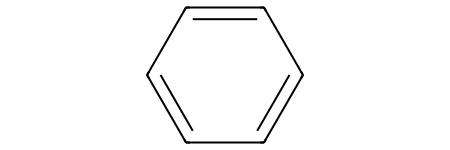

In [3]:
mols = auto2mol.transform(["c1ccccc1"])
mols[0]

The AutoToMol element can also read other molecule formats like SDF  

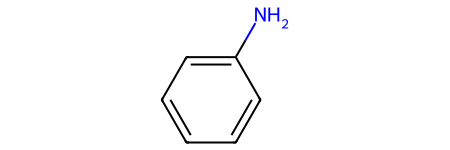

In [4]:
from io import StringIO
from rdkit import rdBase

sio = StringIO()
with rdBase.BlockLogs():
    with Chem.SDWriter(sio) as w:
        w.write(Chem.MolFromSmiles("c1ccccc1N"))
    sdf_string = sio.getvalue()
    mol2 = auto2mol.fit_transform([sdf_string])[0]
mol2

Let's add the created element to a list for later.

In [5]:
read_elements = [("auto2mol", AutoToMolPipelineElement())]

### Standardizing molecules

Usually, many applications and algorithms requiere that molecules are in a particular form. However, molecule data comes in diverse forms and with heterogenous annotations. Therefore, molecule standardization is often necessary. In MolPipeline there are pipeline elements that directly wrap certain RDKit functionalities for standardization which can be used to simply setup custom standardization pipelines. 

We can filter molecules by the elements they contain with the ElementFilterPipelineElement.

In [6]:
# we can say that we only want molecules with carbon, nitrogen and oxygen
element_filter = ElementFilterPipelineElement(allowed_element_numbers=[6, 7, 8])

The following will substitute the second molecule with the Flour atom with a `InvalidInstance` which marks the molecule as invalid (see the notebook on error handling for more details).

In [7]:
mols = auto2mol.transform(["CCC", "CCCF"])
element_filter.transform(mols)

 InvalidInstance(ElementFilterPipelineElement, Molecule contains following forbidden elements: {9})]

We can also standardize the molecules by removing unwanted metals, salts, stereo information and the molecules' charge and compute a canonical tautomer. In contrast to the ElementFilter these pipeline element don't filter out molecules but transform them to different molecules (if possible).

In [8]:
metal_disconnector = MetalDisconnectorPipelineElement()
salt_remover = SaltRemoverPipelineElement()
uncharge = UnchargePipelineElement()
canonical_tautomer = CanonicalizeTautomerPipelineElement()
stereo_remover = RemoveStereoInformationPipelineElement()

In [16]:
TODO: example of mol2mol elements above

SyntaxError: invalid syntax (3082906152.py, line 1)

In [9]:
standardization_elements = [
    ("element_filter", ElementFilterPipelineElement()),
    ("metal_disconnector", MetalDisconnectorPipelineElement()),
    ("salt_remover", SaltRemoverPipelineElement()),
    ("uncharge", UnchargePipelineElement()),
    ("canonical_tautomer", CanonicalizeTautomerPipelineElement()),
    ("stereo_remover", RemoveStereoInformationPipelineElement()),
]

### Feature computation

RDKit provides a wealth of useful molecular descriptors. Here we use the popular Morgan (or ECFP) fingerprints.

In [10]:
morgan2_2048 = MolToFoldedMorganFingerprint(n_bits=2048, radius=2)

In [11]:
featurization_elements = [("morgan2_2048", morgan2_2048)]

### Machine learning model

We can use machine learning estimators from Sklearn natively in MolPipeline.

In [12]:
ml_models = [("RandomForestRegressor", RandomForestRegressor())]

### Putting the pipeline together

We compose a Pipeline from the pipeline elements. The elements in the pipeline will be executed subsequently. First, the given input SMILES will be read to RDKit molecules, then they are standardized and fingerprints are computed. The fingerprints are finally used to fit the RandomForestRegressor.

In [13]:
pipeline = Pipeline(
    read_elements + standardization_elements + featurization_elements + ml_models
)
pipeline.fit(X=["CCCCCC", "c1ccccc1"], y=[0.2, 0.4])

Pipeline(steps=[('auto2mol', AutoToMolPipelineElement()),
                ('element_filter',
                 ElementFilterPipelineElement(allowed_element_numbers={1, 34, 35, 5, 6, 7, 8, 9, 14, 15, 16, 17, 53})),
                ('metal_disconnector', MetalDisconnectorPipelineElement()),
                ('salt_remover', SaltRemoverPipelineElement()),
                ('uncharge', UnchargePipelineElement()),
                ('canonical_tautomer', CanonicalizeTautomerPipelineElement()),
                ('stereo_remover', RemoveStereoInformationPipelineElement()),
                ('morgan2_2048', MolToFoldedMorganFingerprint()),
                ('RandomForestRegressor', RandomForestRegressor())])

Just like in Sklearn we now have an estimator as a pipeline that not only contains the machine learning model but also the transformation steps to go from the raw molecular data to the trained model. We now can make predictions for new molecules:

In [14]:
pipeline.predict(["CCCCC"])

array([0.266])

Instead of training a machine learning model, we can also compose the elements to make a pipeline that computes the molecular fingerprint matrix.

In [15]:
feature_pipeline = Pipeline(
    read_elements + standardization_elements + featurization_elements
)
feature_pipeline.fit_transform(["CCCCCC", "c1ccccc1"]).todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])